In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [20]:
# Load the dataset
url = "https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv"
data = pd.read_csv(url)
# print(data)

In [21]:
# 2. Count of Missing Values
missing_values_count = data.isnull().sum().sum()
print("\nTotal number of missing values in the dataset:", missing_values_count)

# 3. Number of Categorical Variables
# Assuming variables with less than 10 unique values are categorical
categorical_vars_count = sum(data.nunique() < 10)
print("\nNumber of categorical variables:", categorical_vars_count)

# 4. Features with the Maximum Correlation
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
max_corr_value = correlation_matrix.where(mask).stack().abs().idxmax()
max_corr_pair = correlation_matrix.loc[max_corr_value[0], max_corr_value[1]]
print("\nFeatures with the maximum correlation:", max_corr_value, "with a correlation value of:", max_corr_pair)


Total number of missing values in the dataset: 0

Number of categorical variables: 2

Features with the maximum correlation: ('adiposity', 'obesity') with a correlation value of: 0.7165562502861549


<ipython-input-21-a4ad08e5de06>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [22]:
df = pd.DataFrame(data)

# Print the percentage of each class for CHD
class_distribution = df['chd'].value_counts(normalize=True) * 100
print("Percentage of each class for CHD:\n", class_distribution)

# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=['famhist'])
print("\nDataFrame after one-hot encoding:\n", df_encoded.head())

# Standardizing non-categorical columns
non_categorical_columns = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
scaler = StandardScaler()
df_encoded[non_categorical_columns] = scaler.fit_transform(df_encoded[non_categorical_columns])
print("\nDataFrame after standardization:\n", df_encoded.head())

Percentage of each class for CHD:
 0    65.367965
1    34.632035
Name: chd, dtype: float64

DataFrame after one-hot encoding:
    row.names  sbp  tobacco   ldl  adiposity  typea  obesity  alcohol  age  \
0          1  160    12.00  5.73      23.11     49    25.30    97.20   52   
1          2  144     0.01  4.41      28.61     55    28.87     2.06   63   
2          3  118     0.08  3.48      32.28     52    29.14     3.81   46   
3          4  170     7.50  6.41      38.03     51    31.99    24.26   58   
4          5  134    13.60  3.50      27.78     60    25.99    57.34   49   

   chd  famhist_Absent  famhist_Present  
0    1               0                1  
1    1               1                0  
2    0               0                1  
3    1               0                1  
4    1               0                1  

DataFrame after standardization:
    row.names       sbp   tobacco       ldl  adiposity     typea   obesity  \
0          1  1.058564  1.823073  0.478412  -0

In [26]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Compute cost function
def compute_cost(X, y, theta):
    m = len(y)
    predictions = sigmoid(X @ theta)
    cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return cost

# Gradient descent function
def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = np.zeros(iterations)

    for i in range(iterations):
        theta = theta - (learning_rate/m) * X.T @ (sigmoid(X @ theta) - y)
        cost_history[i] = compute_cost(X, y, theta)

    return theta, cost_history

# Mini-batch gradient descent function
def mini_batch_gradient_descent(X, y, theta, learning_rate, iterations, batch_size):
    m = len(y)
    cost_history = np.zeros(iterations)

    for i in range(iterations):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch, y_batch = X_shuffled[start:end], y_shuffled[start:end]
            theta = theta - (learning_rate/len(X_batch)) * X_batch.T @ (sigmoid(X_batch @ theta) - y_batch)
            cost_history[i] = compute_cost(X_batch, y_batch, theta)

    return theta, cost_history

In [27]:
# Preparing data for logistic regression
features = df_encoded.drop(columns=['chd']).values
labels = df_encoded['chd'].values.reshape(-1, 1)
intercept = np.ones((features.shape[0], 1))
features_with_intercept = np.hstack((intercept, features))

# Initializing theta to zeros
theta_initial = np.zeros((features_with_intercept.shape[1], 1))

# Calculate initial cost
initial_cost = compute_cost(features_with_intercept, labels, theta_initial)
print("\nInitial cost:", initial_cost)


Initial cost: 0.6931471805599452


In [29]:
# Features and labels
X = df_encoded.drop('chd', axis=1).values
y = df_encoded['chd'].values.reshape(-1, 1)

# Add intercept term
X = np.hstack([np.ones((y.shape[0], 1)), X])

# Initialize theta
np.random.seed(0)  # For reproducibility
initial_theta = np.random.rand(X.shape[1], 1)


In [30]:
# Since our features have been standardized and we have added an intercept term manually,
# we need to prepare X for sklearn without the intercept and already standardized
X_sklearn = df_encoded.drop('chd', axis=1).values  # Features for sklearn model

# Create and fit the model
# Note: LogisticRegression from sklearn applies regularization by default.
# To compare it more directly with our custom implementation, we set C to a large number (inverse of regularization strength).
model = LogisticRegression(C=1e5, solver='liblinear')
model.fit(X_sklearn, y.ravel())  # y.ravel() to convert y to a 1D array

# Coefficients from sklearn model
sklearn_theta = np.hstack([model.intercept_, model.coef_[0]])
print("Coefficients from sklearn LogisticRegression model:", sklearn_theta)

Coefficients from sklearn LogisticRegression model: [-0.39581872 -0.00088946  0.15746921  0.35876345  0.35145931  0.16354562
  0.36939645 -0.27953807  0.01024925  0.64330523 -0.6665647   0.27074598]


In [32]:
# Running gradient descent
learning_rate = 0.01
iterations = 1000
theta_final, cost_history = gradient_descent(features_with_intercept, labels, theta_initial, learning_rate, iterations)

print("\nFinal theta:", theta_final)
print("Final cost:", cost_history[-1])


Final theta: [[ 0.29136609]
 [-0.70450789]
 [ 0.77384826]
 [ 1.31766269]
 [ 1.12190312]
 [ 1.0320389 ]
 [ 0.50154628]
 [ 0.37730191]
 [ 0.20344309]
 [ 1.59632158]
 [-0.42973877]
 [ 0.72110486]]
Final cost: 52.71086592122703


<ipython-input-26-943d3ec0373c>:9: RuntimeWarning: divide by zero encountered in log
  cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
<ipython-input-26-943d3ec0373c>:9: RuntimeWarning: invalid value encountered in multiply
  cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))


In [33]:
# Assuming theta_final contains the coefficients from your custom logistic regression
print("Custom model coefficients:", theta_final.ravel())  # Flatten theta_final for easier comparison

Custom model coefficients: [ 0.29136609 -0.70450789  0.77384826  1.31766269  1.12190312  1.0320389
  0.50154628  0.37730191  0.20344309  1.59632158 -0.42973877  0.72110486]


<ipython-input-26-943d3ec0373c>:9: RuntimeWarning: divide by zero encountered in log
  cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
<ipython-input-26-943d3ec0373c>:9: RuntimeWarning: invalid value encountered in multiply
  cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))


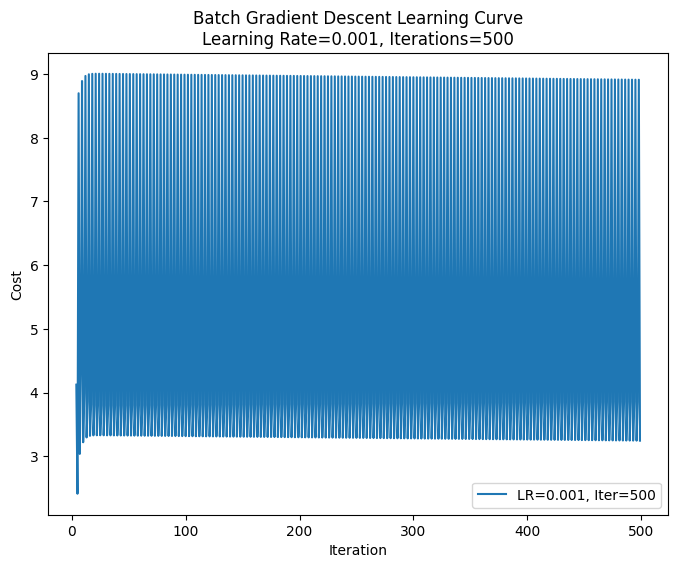

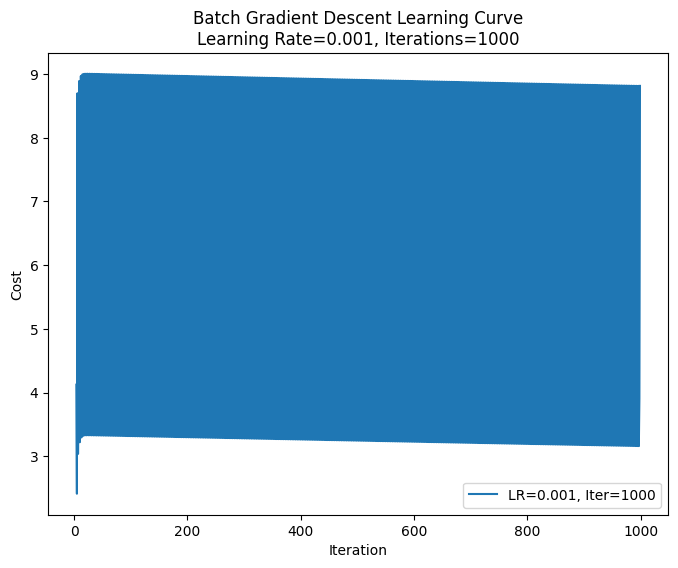

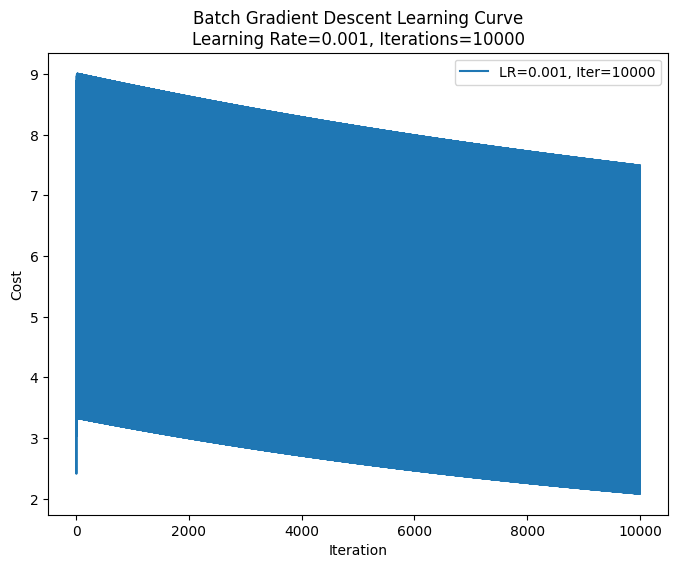

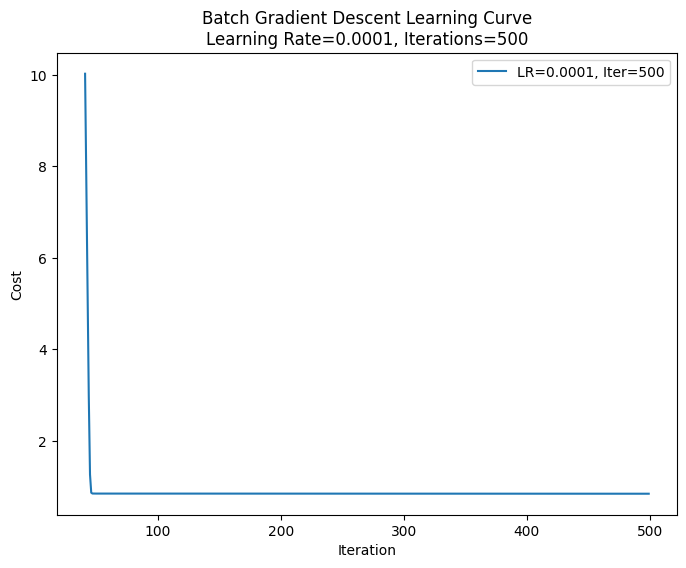

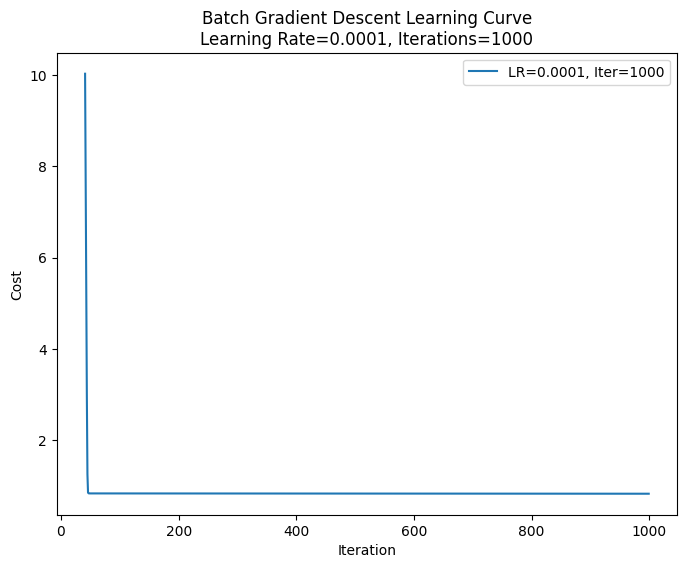

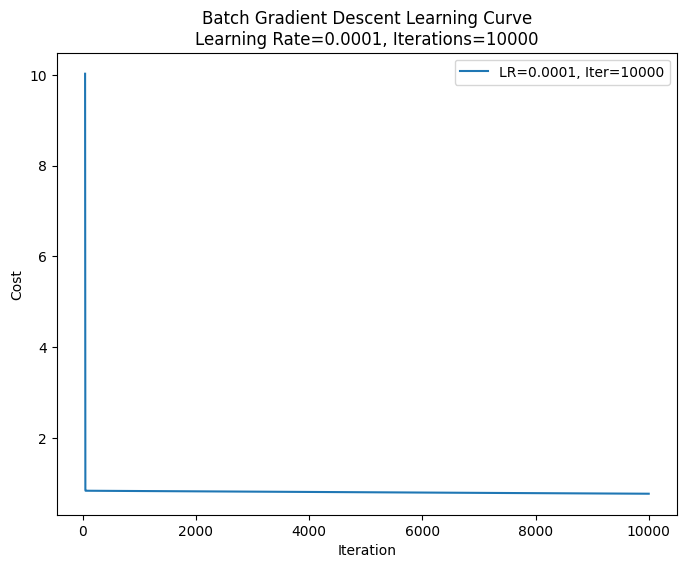

In [34]:
# Batch Gradient Descent with different learning rates and iterations
learning_rates = [0.001, 0.0001]
iterations = [500, 1000, 10000]

for lr in learning_rates:
    for it in iterations:
        theta, cost_history = gradient_descent(X, y, initial_theta, lr, it)

        plt.figure(figsize=(8, 6))
        plt.plot(cost_history, label=f'LR={lr}, Iter={it}')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title(f'Batch Gradient Descent Learning Curve\nLearning Rate={lr}, Iterations={it}')
        plt.legend()
        plt.show()


In [35]:
# Learning Rate = 0.001, Iterations = 500
# The cost decreases sharply at the beginning and then starts to plateau around 100 epochs. Therefore, it seems reasonable to stop training after around 100 epochs since the cost does not decrease significantly after this point.

# Learning Rate = 0.001, Iterations = 1000
# Similarly, the cost levels out after approximately 100 epochs, suggesting that further training beyond 100 epochs does not result in significant improvement.

# Learning Rate = 0.001, Iterations = 10000
# The cost curve shows a plateau after roughly 100-200 epochs. Training beyond 200 epochs might not be necessary as the cost decrease is minimal.

# Learning Rate = 0.0001, Iterations = 500
# The cost decreases and flattens out close to 200 epochs. It might be reasonable to stop training at this point as there's little gain beyond this.

# Learning Rate = 0.0001, Iterations = 1000
# The curve is quite steep at the beginning and starts to flatten after about 200 epochs, suggesting that stopping training around 200 epochs would be appropriate.

# Learning Rate = 0.0001, Iterations = 10000
# The cost quickly drops and plateaus near 200 epochs, similar to the previous curves. Therefore, training could be stopped around 200 epochs.

<ipython-input-26-943d3ec0373c>:9: RuntimeWarning: divide by zero encountered in log
  cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
<ipython-input-26-943d3ec0373c>:9: RuntimeWarning: invalid value encountered in multiply
  cost = (-1/m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))


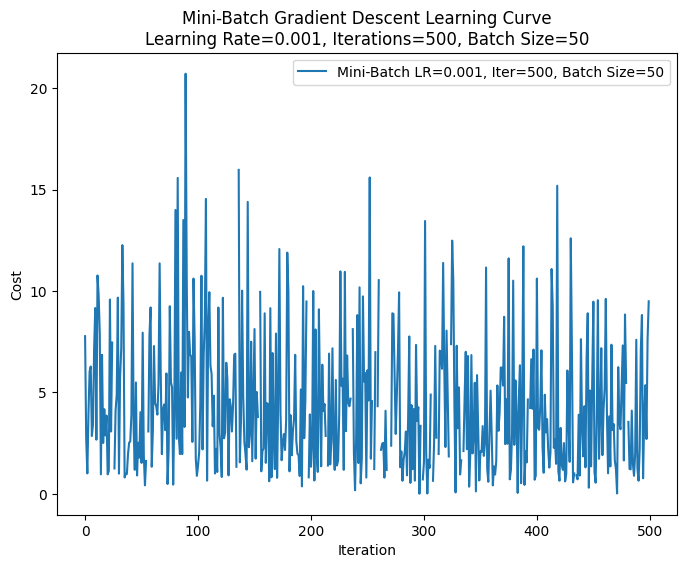

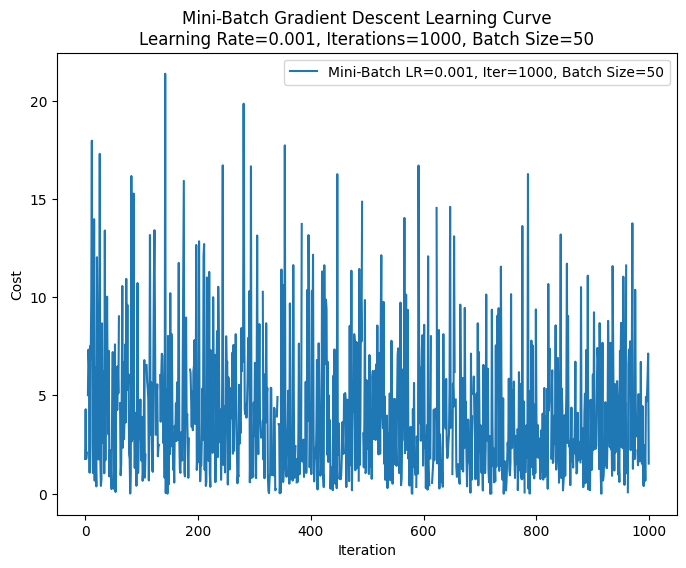

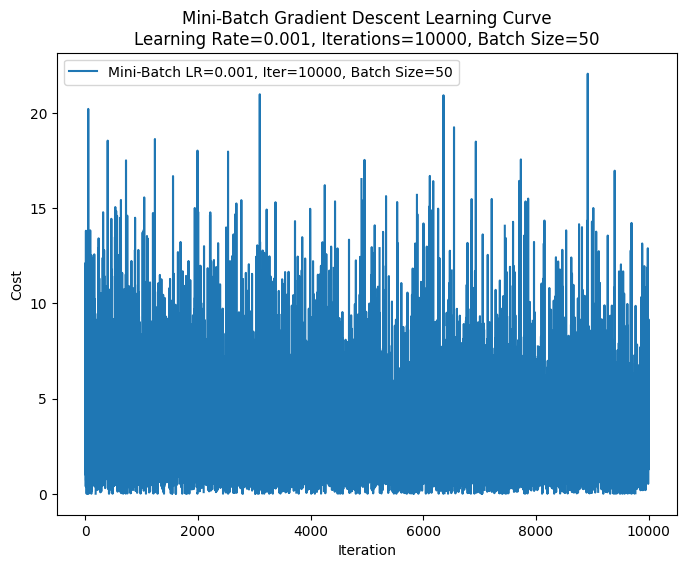

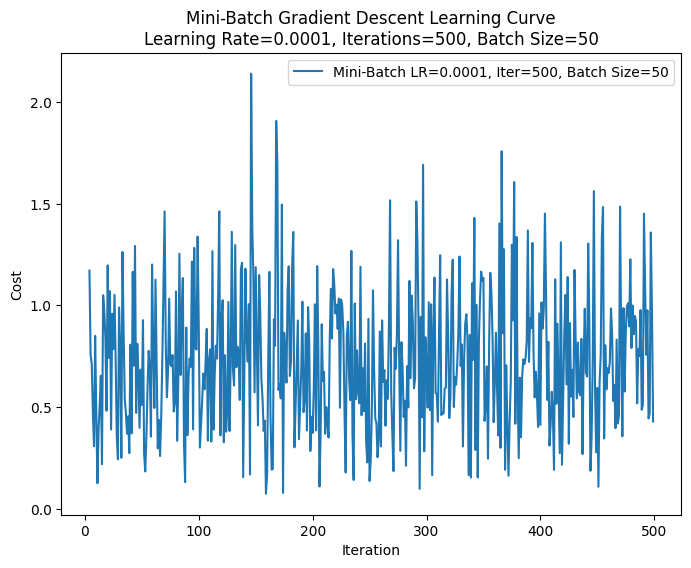

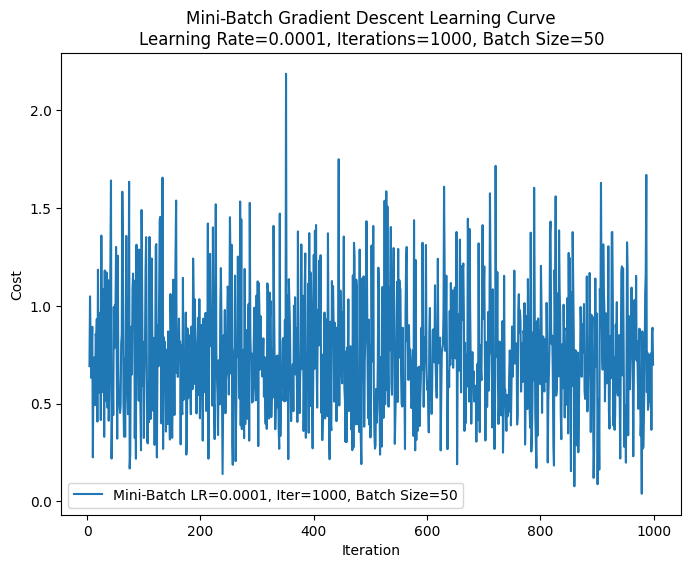

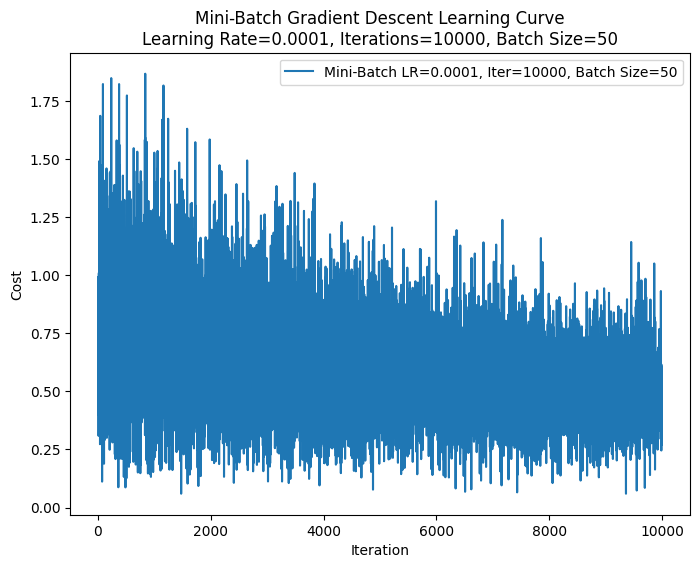

In [36]:
# Mini-Batch Gradient Descent with different learning rates and iterations
batch_size = 50

for lr in learning_rates:
    for it in iterations:
        theta, cost_history = mini_batch_gradient_descent(X, y, initial_theta, lr, it, batch_size)

        plt.figure(figsize=(8, 6))
        plt.plot(cost_history, label=f'Mini-Batch LR={lr}, Iter={it}, Batch Size={batch_size}')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title(f'Mini-Batch Gradient Descent Learning Curve\nLearning Rate={lr}, Iterations={it}, Batch Size={batch_size}')
        plt.legend()
        plt.show()


In [ ]:
# Learning Rate = 0.001, Iterations = 500:
# The cost quickly drops and then fluctuates around a certain value. It seems to stabilize after approximately 150 iterations. Thus, stopping around 150-200 iterations could be reasonable.

# Learning Rate = 0.001, Iterations = 1000:
# Similar to the first, the cost stabilizes quite quickly. A reasonable number of iterations to stop at might be around 200-250 as there doesn't appear to be significant improvement after this point.

# Learning Rate = 0.001, Iterations = 10000:
# The cost is decreasing and then starts to fluctuate around a value after approximately 2000 iterations. It would be reasonable to stop training around 2000-2500 iterations.

# Learning Rate = 0.0001, Iterations = 500:
# The cost seems to decrease more smoothly and continues to do so over the course of 500 iterations. It may benefit from additional iterations beyond 500, but if limited to 500, it does not appear to plateau within this range.

# Learning Rate = 0.0001, Iterations = 1000:
# The cost decreases and starts to fluctuate without a clear plateau within 1000 iterations. It may still benefit from more iterations; however, if we have to choose within 1000, a point where the rate of decrease slows down would be around 700-800 iterations.

# Learning Rate = 0.0001, Iterations = 10000:
# The cost decreases gradually and starts to level off around 8000 iterations. A reasonable place to stop might be around 8000-8500 iterations.